## Middle Exam

#### 資料描述
| date | coupon id |  描述  |
|----:| --------:|-----:|
|  有   |       無      |   平常交易|
|  無   |       有      |   交易完成無使用coupon|
|  有   |       有      |   交易完成使用coupon|

In [173]:
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import warnings
import datetime
data_path = 'data/MiddleExam/'
df = pd.read_csv(data_path + 'train_offline.csv')
df_test = pd.read_csv(data_path + 'test_offline.csv')
df = df[~df.Coupon_id.isna()]
df_test = df_test[~df_test.Coupon_id.isna()]
train_Y = df['Date'].apply(lambda x: 0 if pd.isnull(x) else 1)

df.head(10)
# train_Y.shape

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN
11,253750,8390,7531.0,20:5,0.0,20160327.0,NaN


In [174]:
# 遺漏值填補
df[df.Distance.isna()].head()
df['Distance'] = df['Distance'].fillna(0)
# df[df.Date.isna()].head()

In [175]:
## 特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
df['User_id_hashes'] = df['User_id'].apply(lambda x: hash(x)%15)
merchant_count = df.groupby('Merchant_id')['Merchant_id'].agg({'Merchant_id_count':'size'}).reset_index()
df = pd.merge(df, merchant_count, on='Merchant_id', how='left')
discount_count = df.groupby('Discount_rate')['Discount_rate'].agg({'Discount_rate_count':'size'}).reset_index()
df = pd.merge(df, discount_count, on='Discount_rate', how='left')
distance_count = df.groupby('Distance')['Distance'].agg({'Distance_count':'size'}).reset_index()
df = pd.merge(df, distance_count, on='Distance', how='left')
# df['week'] = df['Date_received'].astype('int').apply(lambda x: datetime.datetime.strftime(xs, '%w')).astype('int64')
df = df.drop({'User_id', 'Merchant_id','Coupon_id', 'Discount_rate', 'Distance','Date'},  axis=1)

df.shape


/Users/fan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/Users/fan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys
/Users/fan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


(746969, 5)

In [176]:
# 分割資料
train_X = MMEncoder.fit_transform(df)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [182]:
# 隨機森林
estimator = RandomForestClassifier()

# cross_val_score(estimator, train_X, train_Y,cv=5).mean()
estimator.fit(train_X, train_Y)
pred_RandFor = estimator.predict_proba(test_X)[:, 1]
fpr_RandFor, tpr_RandFor, _ = roc_curve(test_Y, pred_RandFor)
roc_auc = auc(fpr_RandFor,tpr_RandFor)

/Users/fan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


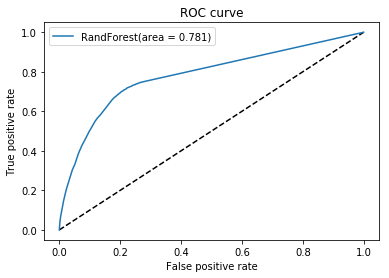

In [183]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_RandFor, tpr_RandFor, label='RandForest(area = %0.3f)'%roc_auc)
# plt.plot(fpr_RandFor_Ir, tpr_RandFor_Ir, label='RandForest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [129]:
# df['week'] = df['Date_received'].astype('int')
df['week'] = pd.to_datetime(df['Date_received'].astype('int'), format='%Y%m%d.0')
# df.head()

ValueError: time data 20160217 does not match format '%Y%m%d.0' (match)